In [93]:
import os, tarfile, math
import pyBigWig
import pybedtools
import zipfile, gzip
from gtfparse import read_gtf
import pandas as pd
pd.set_option('display.max_columns', None)
from Bio import SeqIO
import pandas as pd
import numpy as np
import re 
from collections import Counter
from itertools import product
from collections import Counter
from multiprocessing import Pool

In [2]:
gtf_file_path = "/data/projects/Resources/Gencode_genome_annotation/gencode.v40.annotation.gtf"

In [3]:
def parse_attributes(attribute_string):
    # Split each attribute into key and value, then strip quotes and spaces
    return dict(item.strip().replace('"', '').split(' ') for item in attribute_string if item)

In [4]:
column_names = [
    "seqname", "source", "feature", "start", "end",
    "score", "strand", "frame", "attribute"
]

# Read the GTF file
gtf_df = pd.read_csv(gtf_file_path, sep="\t", comment='#', header=None, names=column_names)

In [5]:
# Step 1: Split the 'attribute' string into a list of strings for each key-value pair
attributes_list = gtf_df['attribute'].str.split(';')


# Apply the function to each row's attribute list
attributes_dicts = attributes_list.apply(parse_attributes)

# Step 3: Convert the list of dictionaries into a DataFrame
attributes_df = pd.DataFrame(list(attributes_dicts))

# Step 4: Combine the new attributes DataFrame with the original gtf_df
# This step assumes that the indexes are aligned and can be directly concatenated
combined_df = pd.concat([gtf_df, attributes_df], axis=1)

# Optionally, you can drop the original 'attribute' column if it's no longer needed
combined_df = combined_df.drop('attribute', axis=1)

In [6]:
combined_df

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,11869,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,NaN,NaN,NaN
3,chr1,HAVANA,exon,12613,12721,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,NaN,NaN,NaN
4,chr1,HAVANA,exon,13221,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283857,chrM,ENSEMBL,transcript,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
3283858,chrM,ENSEMBL,exon,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,1,ENSE00001544475.2,NaN,NaN,NaN
3283859,chrM,ENSEMBL,gene,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283860,chrM,ENSEMBL,transcript,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,ENST00000387461.2,Mt_tRNA,MT-TP-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_gene = combined_df[combined_df["feature"] == "gene"]
df_gene

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,chr1,HAVANA,gene,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,chr1,HAVANA,gene,29554,31109,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,NaN,NaN,NaN,NaN,ncRNA_host,NaN,NaN,NaN,NaN,NaN,NaN
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,ENSG00000284332.1,miRNA,MIR1302-2,3,HGNC:35294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283843,chrM,ENSEMBL,gene,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283848,chrM,ENSEMBL,gene,14674,14742,.,-,.,ENSG00000210194.1,Mt_tRNA,MT-TE,3,HGNC:7479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283851,chrM,ENSEMBL,gene,14747,15887,.,+,.,ENSG00000198727.2,protein_coding,MT-CYB,3,HGNC:7427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283856,chrM,ENSEMBL,gene,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_gene.groupby('gene_type').size()

gene_type
IG_C_gene                                14
IG_C_pseudogene                           9
IG_D_gene                                37
IG_J_gene                                18
IG_J_pseudogene                           3
IG_V_gene                               145
IG_V_pseudogene                         187
IG_pseudogene                             1
Mt_rRNA                                   2
Mt_tRNA                                  22
TEC                                    1057
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_gene                                79
TR_J_pseudogene                           4
TR_V_gene                               106
TR_V_pseudogene                          33
lncRNA                                17748
miRNA                                  1879
misc_RNA                               2212
polymorphic_pseudogene                   50
processed_pseudogene                  10154
protein_coding        

In [9]:
df_gene[df_gene['gene_type']=="protein_coding"]

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
57,chr1,HAVANA,gene,65419,71585,.,+,.,ENSG00000186092.7,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,chr1,HAVANA,gene,450740,451678,.,-,.,ENSG00000284733.2,protein_coding,OR4F29,2,HGNC:31275,OTTHUMG00000002860.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,chr1,HAVANA,gene,685716,686654,.,-,.,ENSG00000284662.2,protein_coding,OR4F16,2,HGNC:15079,OTTHUMG00000002581.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,chr1,HAVANA,gene,923923,944575,.,+,.,ENSG00000187634.13,protein_coding,SAMD11,2,HGNC:28706,OTTHUMG00000040719.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1245,chr1,HAVANA,gene,944203,959309,.,-,.,ENSG00000188976.11,protein_coding,NOC2L,2,HGNC:24517,OTTHUMG00000040720.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283816,chrM,ENSEMBL,gene,10470,10766,.,+,.,ENSG00000212907.2,protein_coding,MT-ND4L,3,HGNC:7460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283823,chrM,ENSEMBL,gene,10760,12137,.,+,.,ENSG00000198886.2,protein_coding,MT-ND4,3,HGNC:7459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283837,chrM,ENSEMBL,gene,12337,14148,.,+,.,ENSG00000198786.2,protein_coding,MT-ND5,3,HGNC:7461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283843,chrM,ENSEMBL,gene,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
combined_df[combined_df["feature"] == "transcript"]

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12010,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
13,chr1,HAVANA,transcript,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,NA,Ensembl_canonical,OTTHUMT00000002839.1,NaN,NaN,PGO:0000005,NaN,NaN
26,chr1,ENSEMBL,transcript,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,transcript,29554,31097,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,5,Ensembl_canonical,OTTHUMT00000002840.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283844,chrM,ENSEMBL,transcript,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,ENST00000361681.2,protein_coding,MT-ND6-201,NA,appris_principal_1,NaN,NaN,NaN,NaN,ENSP00000354665.2,NaN
3283849,chrM,ENSEMBL,transcript,14674,14742,.,-,.,ENSG00000210194.1,Mt_tRNA,MT-TE,3,HGNC:7479,NaN,ENST00000387459.1,Mt_tRNA,MT-TE-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
3283852,chrM,ENSEMBL,transcript,14747,15887,.,+,.,ENSG00000198727.2,protein_coding,MT-CYB,3,HGNC:7427,NaN,ENST00000361789.2,protein_coding,MT-CYB-201,NA,appris_principal_1,NaN,NaN,NaN,NaN,ENSP00000354554.2,NaN
3283857,chrM,ENSEMBL,transcript,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Filter rows where 'feature' is 'transcript' and 'seqname' is not 'chrM'
gtf_transcript = combined_df[(combined_df["feature"] == "transcript") & (combined_df["seqname"] != "chrM")]

# Display the resulting DataFrame
gtf_transcript

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12010,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
13,chr1,HAVANA,transcript,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,NA,Ensembl_canonical,OTTHUMT00000002839.1,NaN,NaN,PGO:0000005,NaN,NaN
26,chr1,ENSEMBL,transcript,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,transcript,29554,31097,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,5,Ensembl_canonical,OTTHUMT00000002840.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283698,chrY,HAVANA,transcript,57209306,57210051,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,1,PAR,OTTHUMT00000058833.1,NaN,NaN,NaN,NaN,NaN
3283701,chrY,HAVANA,transcript,57209887,57212186,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,2,PAR,OTTHUMT00000058827.1,NaN,NaN,NaN,NaN,NaN
3283704,chrY,HAVANA,transcript,57210344,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,1,PAR,OTTHUMT00000058834.1,NaN,NaN,NaN,NaN,NaN
3283708,chrY,HAVANA,transcript,57210591,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,2,PAR,OTTHUMT00000058835.1,NaN,NaN,NaN,NaN,NaN


In [12]:
gtf_transcript.groupby('transcript_type').size()

transcript_type
IG_C_gene                                23
IG_C_pseudogene                           9
IG_D_gene                                37
IG_J_gene                                18
IG_J_pseudogene                           3
IG_V_gene                               145
IG_V_pseudogene                         187
IG_pseudogene                             1
TEC                                    1147
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_gene                                79
TR_J_pseudogene                           4
TR_V_gene                               106
TR_V_pseudogene                          33
lncRNA                                51324
miRNA                                  1879
misc_RNA                               2212
non_stop_decay                           99
nonsense_mediated_decay               20254
polymorphic_pseudogene                   71
processed_pseudogene                  10156
processed_transc

In [13]:
def extract_tss_regions_from_df(tss_df):
    """
    Extracts TSS (+50 and -50 bp) regions from the GTF DataFrame.
    :param df: A pandas DataFrame containing GTF data.
    :return: A DataFrame with TSS regions.
    """

    # Calculate TSS based on strand
    tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)

    # Adjust TSS based on strand for +50 and -50 bp
    tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)
    tss_df['end_adj'] = tss_df.apply(lambda x: x['TSS'] + 45 if x['strand'] == '+' else x['TSS'] + 90, axis=1)

    # Select and rename relevant columns
    tss_regions = tss_df[['seqname', 'TSS','start_adj', 'end_adj', 'strand', 'gene_id', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']]
    tss_regions.columns = ['Chromosome', 'TSS', '45BP_Start', '45BP_End', 'Strand', 'GeneID', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']

    return tss_regions

In [14]:
tss_regions_df = extract_tss_regions_from_df(gtf_transcript)

/tmp/ipykernel_2427171/905394969.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)
/tmp/ipykernel_2427171/905394969.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)
/tmp/ipykernel_2427171/905394969.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [15]:
tss_regions_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name
1,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202
5,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201
13,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201
26,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201
29,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283698,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210
3283701,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215
3283704,chrY,57210344,57210299,57210389,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211
3283708,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205


In [16]:
tss_regions_df[['Chromosome','TSS', '45BP_Start', '45BP_End', "Strand"]].drop_duplicates()

,Chromosome,TSS,45BP_Start,45BP_End,Strand
1,chr1,11869,11824,11914,+
5,chr1,12010,11965,12055,+
13,chr1,29570,29570,29660,-
26,chr1,17436,17436,17526,-
29,chr1,29554,29509,29599,+
...,...,...,...,...,...
3283698,chrY,57209306,57209261,57209351,+
3283701,chrY,57209887,57209842,57209932,+
3283704,chrY,57210344,57210299,57210389,+
3283708,chrY,57210591,57210546,57210636,+


In [17]:
df_promoter_bed = tss_regions_df[['Chromosome', '45BP_Start', '45BP_End']].drop_duplicates().reset_index(drop=True)
df_promoter_bed

,Chromosome,45BP_Start,45BP_End
0,chr1,11824,11914
1,chr1,11965,12055
2,chr1,29570,29660
3,chr1,17436,17526
4,chr1,29509,29599
...,...,...,...
215188,chrY,57209261,57209351
215189,chrY,57209842,57209932
215190,chrY,57210299,57210389
215191,chrY,57210546,57210636


In [18]:
df_promoter_bed.sort_values(by=['Chromosome', '45BP_Start'], inplace=True)
df_merged = df_promoter_bed.groupby('Chromosome').apply(
    lambda x: x.iloc[np.concatenate([ [True], np.diff(x['45BP_Start'].to_numpy()) > 0 ])]
).reset_index(drop=True)
df_merged

/tmp/ipykernel_2427171/3288373515.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_merged = df_promoter_bed.groupby('Chromosome').apply(


,Chromosome,45BP_Start,45BP_End
0,chr1,11824,11914
1,chr1,11965,12055
2,chr1,17436,17526
3,chr1,29509,29599
4,chr1,29570,29660
...,...,...,...
215188,chrY,57209261,57209351
215189,chrY,57209842,57209932
215190,chrY,57210299,57210389
215191,chrY,57210546,57210636


In [19]:
def read_genome(fasta_file):
    """
    Reads a genome fasta file and returns a dictionary of chromosomes and sequences.
    :param fasta_file: Path to the genome fasta file.
    :return: A dictionary with chromosome names as keys and sequences as values.
    """
    genome = {}
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        genome[seq_record.id] = seq_record.seq
    return genome

In [20]:
genome_path = "/data/projects/Resources/Gencode_genome_annotation/GRCh38.primary_assembly.genome.fa"
# Load the genome and TSS regions
genome = read_genome(genome_path)

In [21]:
def find_non_promoters(df, chrom_size):
    non_promoters = []
    start = 0
    for _, row in df.iterrows():
        if start < row['45BP_Start']:
            non_promoters.append((start, row['45BP_Start']))
        start = max(start, row['45BP_End'])
    # Add the last region
    if start < chrom_size:
        non_promoters.append((start, chrom_size))
    return non_promoters

In [22]:
non_promoter_bed = []
for chrom, group in df_merged.groupby('Chromosome'):
    print(chrom)
    sequence = genome[chrom]
    chrom_len = len(sequence)
    non_promoters = find_non_promoters(group, chrom_len)
    for start, end in non_promoters:
        non_promoter_bed.append([chrom, start, end])

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


In [23]:
df_non_promoter_bed = pd.DataFrame(non_promoter_bed, columns=['Chromosome', 'Start', 'End'])
df_non_promoter_bed

,Chromosome,Start,End
0,chr1,0,11824
1,chr1,11914,11965
2,chr1,12055,17436
3,chr1,17526,29509
4,chr1,29660,30222
...,...,...,...
137395,chrY,57209351,57209842
137396,chrY,57209932,57210299
137397,chrY,57210389,57210546
137398,chrY,57210636,57214397


In [24]:
df_non_promoter_bed.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/non_promoter.bed", sep="\t", index=False)

In [25]:
def find_non_promoters_90bp(df, chrom_size):
    non_promoters = []
    interval_length = 90  # Define the length of each interval here
    start = 0
    for _, row in df.iterrows():
        while start < row['45BP_Start']:
            end = min(start + interval_length, row['45BP_Start'])
            non_promoters.append((start, end))
            start = end
        start = max(start, row['45BP_End'])
    # Add the last region
    while start < chrom_size:
        end = min(start + interval_length, chrom_size)
        non_promoters.append((start, end))
        start = end
    return non_promoters

In [26]:
non_promoter_90bp_bed = []
for chrom, group in df_merged.groupby('Chromosome'):
    print(chrom)
    sequence = genome[chrom]
    chrom_len = len(sequence)
    non_promoters = find_non_promoters_90bp(group, chrom_len)
    for start, end in non_promoters:
        non_promoter_90bp_bed.append([chrom, start, end])

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


In [52]:
df_non_promoter_90bp_bed = pd.DataFrame(non_promoter_90bp_bed, columns=['Chromosome', '45BP_Start', '45BP_End'])
df_non_promoter_90bp_bed

,Chromosome,45BP_Start,45BP_End
0,chr1,0,90
1,chr1,90,180
2,chr1,180,270
3,chr1,270,360
4,chr1,360,450
...,...,...,...
34227820,chrY,57226997,57227087
34227821,chrY,57227087,57227177
34227822,chrY,57227177,57227267
34227823,chrY,57227267,57227357


In [28]:
df_non_promoter_90bp_bed.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/non_promoter_90bp.bed", sep="\t", index=False)

In [53]:
df_temp = df_non_promoter_90bp_bed[(df_non_promoter_90bp_bed['Chromosome']=="chr1") | (df_non_promoter_90bp_bed['Chromosome']=="chr2") ]
df_temp

,Chromosome,45BP_Start,45BP_End
0,chr1,0,90
1,chr1,90,180
2,chr1,180,270
3,chr1,270,360
4,chr1,360,450
...,...,...,...
16941782,chr2,242193136,242193226
16941783,chr2,242193226,242193316
16941784,chr2,242193316,242193406
16941785,chr2,242193406,242193496


In [54]:
def fetch_sequences_for_regions(df, genome):
    """
    Fetches sequences for regions specified in the DataFrame from the genome.
    :param df: DataFrame with the regions (must contain 'Chromosome', '45BP_Start', '45BP_End' columns).
    :param genome: Dictionary of genome sequences.
    :return: DataFrame with the original information and an additional 'Sequence' column.
    """
    sequences = []
    for index, row in df.iterrows():
        seq = str(genome[row['Chromosome']][row['45BP_Start']:row['45BP_End']].upper())
        sequences.append(seq)
    df['Sequence'] = sequences
    print(df.shape)
    return df

In [56]:
def parallel_fetch_sequences(df, genome, num_processes=45):
    """
    Fetches sequences in parallel using multiprocessing.
    :param df: Complete DataFrame
    :param genome: Genome dictionary
    :param num_processes: Number of processes to use
    :return: DataFrame with sequences added
    """
    df_split = np.array_split(df, num_processes)  # Split DataFrame into chunks
    pool = Pool(processes=num_processes)
    results = pool.starmap(fetch_sequences_for_regions, [(chunk, genome) for chunk in df_split])
    pool.close()
    pool.join()
    return pd.concat(results) 

In [57]:
df_with_sequences = parallel_fetch_sequences(df_temp, genome)

(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120961, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)
(120960, 4)


In [58]:
df_with_sequences

,Chromosome,45BP_Start,45BP_End,Sequence
0,chr1,0,90,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,chr1,90,180,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,chr1,180,270,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,chr1,270,360,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,chr1,360,450,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...,...,...
16941782,chr2,242193136,242193226,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
16941783,chr2,242193226,242193316,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
16941784,chr2,242193316,242193406,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
16941785,chr2,242193406,242193496,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [59]:
# Fetch sequences
# sequences = fetch_sequences_for_regions(df_non_promoter_90bp_bed, genome)

In [60]:
# df_non_promoter_90bp_bed['Sequence'] = sequences  # Add sequences to the DataFrame
# df_non_promoter_90bp_bed

In [61]:
df_non_promoter_90bp_bed = df_with_sequences[~df_with_sequences['Sequence'].str.contains('N')]
df_non_promoter_90bp_bed

,Chromosome,45BP_Start,45BP_End,Sequence
112,chr1,10080,10170,ACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCT...
113,chr1,10170,10260,ACCCTAACCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT...
114,chr1,10260,10350,TAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAAC...
115,chr1,10350,10440,CTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAA...
116,chr1,10440,10530,CCCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCCTCAGCCGG...
...,...,...,...,...
16941670,chr2,242183056,242183146,GGGCCGCATCGACGGTGAATAAAATCTTTCCTGTTTGCTGCCCTGA...
16941671,chr2,242183146,242183236,CGGGAAACGAAAAGCCTCTCTGAATCCTGCGCACCGAGATTCTCCC...
16941672,chr2,242183236,242183326,AGAACTCAAATGCAGCATTCCTAATGCACACATGACACCCTAAATA...
16941673,chr2,242183326,242183416,TCGGGTTCGGGTTCGGGTTCGGGTTAGGGGGTTAGGGTTAGGGTTG...


## PWM(Position weight matrix) generation

In [62]:
TATA_PFM_file_path = '/home/campus.stonybrook.edu/pdutta/Github/Postdoc/DNABERT_data_processing/Core_promoter/POL012.1.pfm'

## Creating Position Frequency Matrix(PFM)

In [63]:
# Parsing the PFM data from the text file
pfm = {}
nucleotides = ['A', 'C', 'G', 'T']

with open(TATA_PFM_file_path, 'r') as file:
    pfm_data = file.readlines()[1:]  # Skip the first line (header)

for line in pfm_data:
    parts = line.split()
    nt = parts[0]
    counts = [float(count) for count in parts[1:]]

    if nt in nucleotides:
        for i, count in enumerate(counts):
            if i not in pfm:
                pfm[i] = {}
            pfm[i][nt] = count

In [64]:
pfm

{0: {'A': 61.0, 'C': 145.0, 'G': 152.0, 'T': 31.0},
 1: {'A': 16.0, 'C': 46.0, 'G': 18.0, 'T': 309.0},
 2: {'A': 352.0, 'C': 0.0, 'G': 2.0, 'T': 35.0},
 3: {'A': 3.0, 'C': 10.0, 'G': 2.0, 'T': 374.0},
 4: {'A': 354.0, 'C': 0.0, 'G': 5.0, 'T': 30.0},
 5: {'A': 268.0, 'C': 0.0, 'G': 0.0, 'T': 121.0},
 6: {'A': 360.0, 'C': 3.0, 'G': 10.0, 'T': 6.0},
 7: {'A': 222.0, 'C': 2.0, 'G': 44.0, 'T': 121.0},
 8: {'A': 155.0, 'C': 44.0, 'G': 157.0, 'T': 33.0},
 9: {'A': 56.0, 'C': 135.0, 'G': 150.0, 'T': 48.0},
 10: {'A': 83.0, 'C': 147.0, 'G': 128.0, 'T': 31.0},
 11: {'A': 82.0, 'C': 127.0, 'G': 128.0, 'T': 52.0},
 12: {'A': 82.0, 'C': 118.0, 'G': 128.0, 'T': 61.0},
 13: {'A': 68.0, 'C': 107.0, 'G': 139.0, 'T': 75.0},
 14: {'A': 77.0, 'C': 101.0, 'G': 140.0, 'T': 71.0}}

## Creating Position Weight Matrix(PWM)

In [65]:
# Background nucleotide probabilities (assuming equal distribution)
background = {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}

# Convert PFM to probabilities and then to PWM (log-likelihood ratios)
pwm = {}
for pos, counts in pfm.items():
    #print(pos, counts)
    total_counts = sum(counts.values())
    #print(total_counts)
    pwm[pos] = {}
    for nt, count in counts.items():
        #print(nt, count)
        probability = (count+ (math.sqrt(total_counts)/4)) / (total_counts+math.sqrt(total_counts))
        #print(probability, background[nt])
        pwm[pos][nt] = np.log2(probability / background[nt])

In [66]:
pwm_df = pd.DataFrame.from_dict(pwm).reset_index(drop=False)
#pwm_df.reset_index(inplace=True)
pwm_df = pwm_df.set_index('index')

# Transpose DataFrame to make columns as positions and rows as nucleotides
pwm_df = pwm_df.T
pwm_df

index,A,C,G,T
0,-0.632100,0.553173,0.619005,-1.507832
1,-2.287426,-1.004514,-2.155767,1.619323
2,1.804521,-4.373167,-3.881964,-1.355551
3,-3.687519,-2.774763,-3.881964,1.890811
4,1.812582,-4.373167,-3.363074,-1.548553
5,1.417411,-4.373167,-4.373167,0.301507
6,1.872907,-3.662510,-2.744280,-3.196441
7,1.151129,-3.881964,-1.062310,0.301507
8,0.646324,-1.062310,0.664253,-1.429683
9,-0.745881,0.453590,0.600500,-0.948945


In [67]:
len(pwm_df)

15

In [68]:
def calculate_relative_score(pwm_df, sequence, start_range, end_range):
    best_score = 0  # Initialize with a very low score
    best_position = None
    for i in range(start_range, end_range + 1 - len(pwm_df)):  # Adjust range for segment length
        segment = sequence[i:i + len(pwm_df)]
        # if len(segment) != len(pwm_df):
        #     raise ValueError("Sequence length must match PWM length")
        absolute_score = sum(pwm_df[nt][pos] for pos, nt in enumerate(segment))
        min_possible_score = pwm_df.min(axis=1).sum()
        max_possible_score = pwm_df.max(axis=1).sum()
        relative_score = (absolute_score - min_possible_score) / (max_possible_score - min_possible_score)
        if relative_score > best_score:
            best_score = relative_score
            best_position = i
    return best_score, best_position

In [47]:
def process_sequences(df_chunk, pwm_df):
    scores_positions = df_chunk['Sequence'].apply(
        lambda seq: calculate_relative_score(pwm_df, seq, 0, 70))
    print("done")
    return pd.DataFrame(scores_positions.tolist(), columns=['Relative_Score', 'Position'], index=df_chunk.index)

In [69]:
def parallel_process_sequences(df, pwm_df, num_processes=45):
    df_split = np.array_split(df, num_processes)
    pool = Pool(processes=num_processes)
    results = pool.starmap(process_sequences, [(chunk, pwm_df) for chunk in df_split])
    pool.close()
    pool.join()
    combined_df = pd.concat(results)
    #print(combined_df)
    df['Relative_Score'], df['Position'] = combined_df['Relative_Score'], combined_df['Position']
    return df

In [70]:
df_results = parallel_process_sequences(df_non_promoter_90bp_bed, pwm_df)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


/tmp/ipykernel_2427171/735914028.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Relative_Score'], df['Position'] = combined_df['Relative_Score'], combined_df['Position']
/tmp/ipykernel_2427171/735914028.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Relative_Score'], df['Position'] = combined_df['Relative_Score'], combined_df['Position']


In [71]:
df_results

,Chromosome,45BP_Start,45BP_End,Sequence,Relative_Score,Position
112,chr1,10080,10170,ACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCT...,0.509594,19
113,chr1,10170,10260,ACCCTAACCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT...,0.540812,4
114,chr1,10260,10350,TAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAAC...,0.530982,21
115,chr1,10350,10440,CTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAA...,0.508577,0
116,chr1,10440,10530,CCCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCCTCAGCCGG...,0.547136,18
...,...,...,...,...,...,...
16941670,chr2,242183056,242183146,GGGCCGCATCGACGGTGAATAAAATCTTTCCTGTTTGCTGCCCTGA...,0.776238,16
16941671,chr2,242183146,242183236,CGGGAAACGAAAAGCCTCTCTGAATCCTGCGCACCGAGATTCTCCC...,0.666921,17
16941672,chr2,242183236,242183326,AGAACTCAAATGCAGCATTCCTAATGCACACATGACACCCTAAATA...,0.800817,39
16941673,chr2,242183326,242183416,TCGGGTTCGGGTTCGGGTTCGGGTTAGGGGGTTAGGGTTAGGGTTG...,0.542430,20


In [73]:
df_results.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/best_relative_score_nonTATA.tsv", sep="\t", index= False)

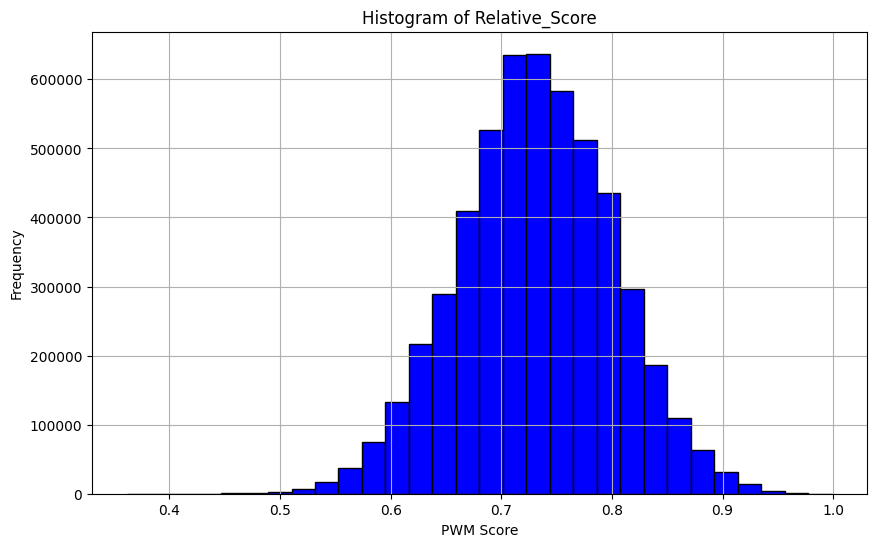

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume unique_tss_df is your DataFrame and PWM_Score is already calculated
# Plotting the distribution of PWM_Score


# # Determine the range of PWM scores
# min_score = unique_tss_df['PWM_Score'].min()
# max_score = unique_tss_df['PWM_Score'].max()

# # Create bins from min to max with each bin covering a range of 5 units
# bins = np.arange(min_score, max_score + 5, 5)  # +5 in max_score for inclusive range on the upper end
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(df_results['Relative_Score'], bins=30, color='blue', edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Relative_Score')  # Title of the histogram
plt.xlabel('PWM Score')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Add grid for better visibility of scales
plt.show()

In [113]:
score_threshold = 0.75  # Placeholder value
# Filter dataframe for sequences predicted to contain a TATA core promoter
selected_df = df_results[df_results['Relative_Score'] > score_threshold]
selected_df

,Chromosome,45BP_Start,45BP_End,Sequence,Relative_Score,Position
128,chr1,11520,11610,GGATTCCTGGGTTTAAAAGTAAAAAATAAATATGTTTAATTTGTGA...,0.830804,10
130,chr1,11700,11790,TTGGGCTGGGGCCTGGCCATGTGTATTTTTTTAAATTTCCACTGAT...,0.767882,28
131,chr1,11790,11824,CCGGATTTCCTTTGCTGTTCCTGCATGTAGTTTA,0.777858,29
142,chr1,12865,12955,GCGGTGGCCTATAAAGCCTCCTAGTCTGGCTCCAAGGCCTGGCAGA...,0.840716,8
153,chr1,13855,13945,TCTATAATAACTAAAGTTAGCTGCCCTGGACTATTCACCCCCTAGT...,0.809797,1
...,...,...,...,...,...,...
16941654,chr2,242181616,242181706,AGAGGCAGGAATGTGAAGAAGTCCAAAATAAAAATCCCTGCACAGG...,0.847274,25
16941657,chr2,242181886,242181976,GACTTTAAGTGGTGCAGGAGGCGGCCAGTAGGGGACGCCAGCCGTT...,0.764559,2
16941669,chr2,242182966,242183056,TCAGCACAGACGTGGGGGGCACCGTAAAGGCGGAGCAGCATTCTTC...,0.762023,21
16941670,chr2,242183056,242183146,GGGCCGCATCGACGGTGAATAAAATCTTTCCTGTTTGCTGCCCTGA...,0.776238,16


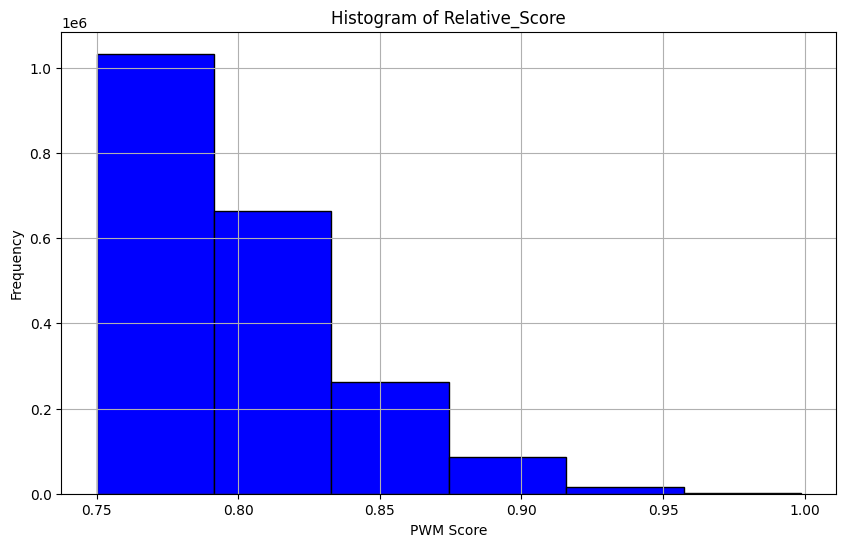

In [114]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(selected_df['Relative_Score'], bins=6, color='blue', edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Relative_Score')  # Title of the histogram
plt.xlabel('PWM Score')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Add grid for better visibility of scales
plt.show()

In [115]:
tata_core_df = selected_df[(selected_df['Position'] >= 10) & (selected_df['Position'] <= 20)]
tata_core_df

,Chromosome,45BP_Start,45BP_End,Sequence,Relative_Score,Position
128,chr1,11520,11610,GGATTCCTGGGTTTAAAAGTAAAAAATAAATATGTTTAATTTGTGA...,0.830804,10
269,chr1,24366,24456,TTATCCGTGGCTGGATATATAGAGATTCCCACACTGCCTTGCACAC...,0.832594,14
287,chr1,25986,26076,AATAATAATTTGTATATTTTACATAACGCACCACACCAACATCTTC...,0.770914,18
306,chr1,27696,27786,TATATCTGGTAGCTTTTAAATGATGACCATGTAGATAATCTTTATT...,0.781933,13
333,chr1,30200,30222,TAGTGAAAAGCTGGTAAAAAGA,0.786907,13
...,...,...,...,...,...,...
16941579,chr2,242174817,242174907,AGGTTAGAAAATGTATGAATATACCATCTCCCAACATCTAGAGGGA...,0.793282,12
16941590,chr2,242175856,242175946,TTTTATTACACCAAAAATACTATATTAATCTTATTTAACTAAGTTT...,0.762566,19
16941625,chr2,242179006,242179096,AGGAGGAGTCATGAATATTTATGGAAGGAGAAATGCATGCACGCAC...,0.825353,14
16941632,chr2,242179636,242179726,ATTTAAATAATCTTTATAACAACTTTTGATGTCTGAGTGGATTCCC...,0.781602,11


In [116]:
tata_core_df.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/TATA_negative_master.tsv", sep="\t", index=False)

In [117]:
score_threshold = 0.75  # Placeholder value
# Filter dataframe for sequences predicted to contain a TATA core promoter
selected_df = df_results[df_results['Relative_Score'] < score_threshold]
selected_df

,Chromosome,45BP_Start,45BP_End,Sequence,Relative_Score,Position
112,chr1,10080,10170,ACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCT...,0.509594,19
113,chr1,10170,10260,ACCCTAACCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT...,0.540812,4
114,chr1,10260,10350,TAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAAC...,0.530982,21
115,chr1,10350,10440,CTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAA...,0.508577,0
116,chr1,10440,10530,CCCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCCTCAGCCGG...,0.547136,18
...,...,...,...,...,...,...
16941667,chr2,242182786,242182876,CGCCTTTGCGAGGGCGGAGTTGCGTTCTCTTTAGCACACACCCGGA...,0.639579,26
16941668,chr2,242182876,242182966,GGGGGTATTGCGAAGGCGGAGCAGAGTTCTTCTCAGGTCAGACCCG...,0.631545,4
16941671,chr2,242183146,242183236,CGGGAAACGAAAAGCCTCTCTGAATCCTGCGCACCGAGATTCTCCC...,0.666921,17
16941673,chr2,242183326,242183416,TCGGGTTCGGGTTCGGGTTCGGGTTAGGGGGTTAGGGTTAGGGTTG...,0.542430,20


In [118]:
tata_negative_core_df = selected_df[(selected_df['Position'] > 10) & (selected_df['Position'] < 20)]
tata_negative_core_df

,Chromosome,45BP_Start,45BP_End,Sequence,Relative_Score,Position
112,chr1,10080,10170,ACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCT...,0.509594,19
116,chr1,10440,10530,CCCTAACCCTAACCCTAACCCTAACCCTCGCGGTACCCTCAGCCGG...,0.547136,18
117,chr1,10530,10620,CAGAGTACCACCGAAATCTGTGCAGAGGACAACGCAGCTCCGCCCT...,0.613599,13
125,chr1,11250,11340,CTGCAGGGCTCTCTTGCTTAGAGTGGTGGCCAGCGCCCCCTGCTGG...,0.647818,15
126,chr1,11340,11430,CACGCCGCCTGCTGGCAGCTAGGGACATTGCAGGGTCCTCTTGCTC...,0.581248,14
...,...,...,...,...,...,...
16941646,chr2,242180896,242180986,TTTCCTCTATAGTTTCTTCTAGAAATTGTATAGTTTTGCATTTTTA...,0.732793,18
16941652,chr2,242181436,242181526,GTGACCGCTGTCAGCCTGCCTGGTATGGCGGGAAGGAGGCTGGTGC...,0.611384,18
16941660,chr2,242182156,242182246,CAGGGGGCGCTGGACAGCACTGTAAGCAAGAGGGCCCTGCAGTTGT...,0.651347,19
16941663,chr2,242182426,242182516,CAGCCCAGCGACGTGCGTCTCTGCGCCTGCGCCGCGCCTCACTCCC...,0.537529,14


In [119]:
tata_negative_core_df.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/NonTATA_negative_master.tsv", sep="\t", index=False)

In [ ]:
# Initialize a list to hold results
results = []
#[f'chr{i}' for i in range(1, 23)] +
# Iterate through specified chromosomes only
for chrom in [f'chr{i}' for i in range(1, 23)]:
    sequence = genome[chrom]  # Fetch the sequence for the chromosome
    length = len(sequence)
    print(chrom)
    #print(sequence[0:10])

    # Break down the chromosome into 100 bp segments and search
    for i in range(0, length - 90 + 1, 45):  # 50 bp step for some overlap; adjust as needed
        segment = str(sequence[i:i+90]).upper()  # Ensure segment is a string and uppercase
        #print(segment)
        # Check if segment is a proper string before processing
        if isinstance(segment, str):
            for pos in find_tata_box_stringent(segment):
                if 75 <= pos <= 81:
                    results.append({
                        'Chromosome': chrom,
                        'Start': i,
                        'End': i + 100,
                        'TATA_Box_Position': pos,
                        'Sequence': segment
                    })
        else:
            print(f"Non-string segment detected at {chrom}:{i}-{i+100}")

# Convert results into a DataFrame
tata_box_df = pd.DataFrame(results)

In [ ]:
tata_box_df

In [ ]:
# Convert DataFrames to BED format for pybedtools
tata_box_bed = pybedtools.BedTool.from_dataframe(tata_box_df[['Chromosome', 'Start', 'End']])
tata_core_bed = pybedtools.BedTool.from_dataframe(tata_core_df[['Chromosome', '50BP_Start', '50BP_End']])
# Use the intersect function with the -v option to get non-intersecting regions
non_intersecting = tata_box_bed.intersect(tata_core_bed, v=True)

In [ ]:
# Convert back to DataFrame
non_intersecting_df = non_intersecting.to_dataframe(names=['Chromosome', 'Start', 'End'])

# You might want to merge back additional information from tata_box_df if needed
tata_box_df_filtered = pd.merge(non_intersecting_df, tata_box_df, on=['Chromosome', 'Start', 'End'])

In [ ]:
tata_box_df_filtered

In [ ]:
tata_box_df_filtered.to_csv("/data/private/pdutta/DNABERT_data/Core_Prom_new/TATA/raw_negative_all.tsv", sep="\t", index=False)

In [ ]:
tata_box_df_filtered_sample = tata_box_df_filtered.sample(n=8500, random_state=1).reset_index(drop=True)

In [ ]:
tata_box_df_filtered_sample

In [ ]:
tata_box_df_filtered_sample.to_csv("/data/private/pdutta/DNABERT_data/Core_Prom_new/TATA/raw_negative.tsv", sep="\t", index=False)

In [ ]:
df_pos

In [ ]:
df_pos['Label']=1

In [ ]:
df_pos = df_pos.reset_index(drop=True)
df_pos

In [ ]:
df_pos.to_csv("/data/projects/DNABERT_data/Core_promoters/Core_promoter_regions/positive_set.tsv", sep="\t", index=False)